<div style="float:right; padding-top: 15px; padding-right: 15px">
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="250">
        </a>
    </div>
</div>

# natural language processing basics

## 0. python imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from hdbscan import HDBSCAN
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

## 1. data loading

list of titles of best 100 films ever made...

In [2]:
titles = open('data/title_list.txt').read().split('\n')[0:100]

titles[:15]

['The Godfather',
 'The Shawshank Redemption',
 "Schindler's List",
 'Raging Bull',
 'Casablanca',
 "One Flew Over the Cuckoo's Nest",
 'Gone with the Wind',
 'Citizen Kane',
 'The Wizard of Oz',
 'Titanic',
 'Lawrence of Arabia',
 'The Godfather: Part II',
 'Psycho',
 'Sunset Blvd.',
 'Vertigo']

In [3]:
synopses = open('data/synopses_list.txt').read().split('\n BREAKS HERE')[0:100]

synopses[:1]

[' Plot  [edit]  [  [  edit  edit  ]  ]  \n  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson

## 2. data processing

In [4]:
parser = English()

In [5]:
import re

def spacy_tokenizer(sentence):

    tokens = parser(sentence)
    
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [6]:
spacy_tokenizer(synopses[0])[:15]

['plot',
 'edit',
 'edit',
 'edit',
 'day',
 'daughter',
 'wedding',
 'vito',
 'corleone',
 'hears',
 'requests',
 'role',
 'godfather',
 'don',
 'new']

## 3. term-frequency matrix

In [7]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.15, tokenizer=spacy_tokenizer)
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
tfidf_matrix.shape

(100, 254)

In [8]:
tfidf_matrix.todense()

matrix([[0.        , 0.0646389 , 0.        , ..., 0.06287008, 0.15909979,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.13310761, 0.        ,
         0.        ],
        [0.        , 0.07322815, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.12629406, 0.        , ..., 0.        , 0.        ,
         0.05978447],
        [0.10964721, 0.08232723, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.12432828, 0.        ,
         0.12101952]])

In [9]:
terms = tfidf_vectorizer.get_feature_names()

terms[:15]

['able',
 'agrees',
 'air',
 'american',
 'apartment',
 'army',
 'arrive',
 'arrives',
 'asks',
 'attack',
 'attempt',
 'attempts',
 'attention',
 'away',
 'battle']

In [10]:
dist = 1 - cosine_similarity(tfidf_matrix)

dist

array([[-2.22044605e-16,  8.71403386e-01,  8.82700207e-01, ...,
         7.56453457e-01,  8.81292056e-01,  8.72030953e-01],
       [ 8.71403386e-01,  0.00000000e+00,  7.72031866e-01, ...,
         8.09164566e-01,  8.36998279e-01,  8.92111515e-01],
       [ 8.82700207e-01,  7.72031866e-01, -2.22044605e-16, ...,
         8.09233859e-01,  8.53123482e-01,  7.58211878e-01],
       ...,
       [ 7.56453457e-01,  8.09164566e-01,  8.09233859e-01, ...,
         0.00000000e+00,  7.04903724e-01,  9.23311908e-01],
       [ 8.81292056e-01,  8.36998279e-01,  8.53123482e-01, ...,
         7.04903724e-01, -2.22044605e-16,  8.79640027e-01],
       [ 8.72030953e-01,  8.92111515e-01,  7.58211878e-01, ...,
         9.23311908e-01,  8.79640027e-01,  2.22044605e-16]])

## 4. text clustering

In [11]:
umap = UMAP(n_neighbors=5, random_state=42)
embedding = umap.fit_transform(dist)

In [12]:
embedding[:5,:]

array([[ 8.111025 , 12.266072 ],
       [11.373111 ,  7.6029315],
       [ 6.858699 , 10.461804 ],
       [12.520336 ,  8.413373 ],
       [ 9.441401 ,  7.4772997]], dtype=float32)

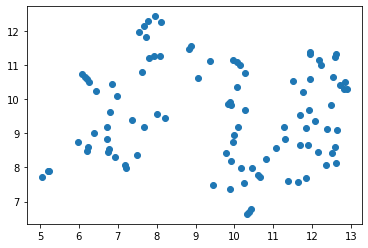

In [13]:
plt.scatter(embedding[:,0], embedding[:,1]);

In [14]:
hdbscan = HDBSCAN(min_cluster_size=5)
clustering = hdbscan.fit_predict(embedding)
np.unique(clustering)

array([-1,  0,  1,  2,  3,  4])

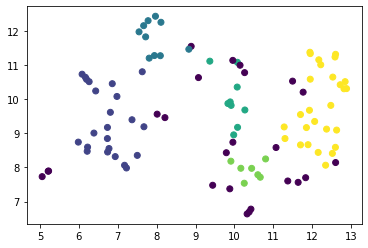

In [15]:
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);

In [16]:
films = pd.DataFrame({'cluster': clustering, 'title': titles, 'synopsis': synopses})

In [17]:
films

,cluster,title,synopsis
0,1,The Godfather,Plot [edit] [ [ edit edit ] ] \n On ...
1,-1,The Shawshank Redemption,Plot [edit] [ [ edit edit ] ] \n In ...
2,0,Schindler's List,Plot [edit] [ [ edit edit ] ] \n In ...
3,4,Raging Bull,Plot [edit] [ [ edit edit ] ] \n In ...
4,-1,Casablanca,Plot [edit] [ [ edit edit ] ] \n It ...
5,-1,One Flew Over the Cuckoo's Nest,Plot [edit] [ [ edit edit ] ] \n In ...
6,1,Gone with the Wind,Plot [edit] [ [ edit edit ] ] \n \nP...
7,2,Citizen Kane,Plot [edit] [ [ edit edit ] ] \n \n\...
8,-1,The Wizard of Oz,Plot [edit] [ [ edit edit ] ] \n The...
9,4,Titanic,Plot [edit] [ [ edit edit ] ] \n In ...


In [18]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,able,agrees,air,american,apartment,army,arrive,arrives,asks,attack,...,window,woman,work,working,world,wounded,year,years,york,young
0,0.0,0.064639,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.053967,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.07811,0.062870,0.159100,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.074787,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.091133,0.073637,0.0,0.00000,0.133108,0.000000,0.0
2,0.0,0.073228,0.000000,0.000000,0.0,0.121965,0.000000,0.146456,0.061139,0.0,...,0.0,0.0,0.000000,0.000000,0.197012,0.0,0.00000,0.000000,0.000000,0.0
3,0.0,0.000000,0.069901,0.089895,0.0,0.085550,0.000000,0.000000,0.128654,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.06207,0.000000,0.189641,0.0
4,0.0,0.069514,0.000000,0.081106,0.0,0.077186,0.075976,0.000000,0.000000,0.0,...,0.0,0.0,0.079747,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0


In [19]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

get_df_from_cluster(0)

,able,agrees,air,american,apartment,army,arrive,arrives,asks,attack,...,window,woman,work,working,world,wounded,year,years,york,young
2,0.000000,0.073228,0.000000,0.000000,0.0,0.121965,0.000000,0.146456,0.061139,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.197012,0.000000,0.0,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.074369,0.0,0.176937,0.000000,0.000000,0.053217,0.077024,...,0.00000,0.000000,0.000000,0.000000,0.171486,0.000000,0.0,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.172417,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
24,0.000000,0.000000,0.000000,0.000000,0.0,0.103461,0.067893,0.000000,0.103726,0.000000,...,0.00000,0.000000,0.213789,0.082732,0.100274,0.238274,0.0,0.000000,0.000000,0.000000
29,0.000000,0.000000,0.325392,0.000000,0.0,0.168951,0.047515,0.000000,0.000000,0.315204,...,0.00000,0.000000,0.000000,0.057900,0.046784,0.000000,0.0,0.042284,0.000000,0.000000
31,0.000000,0.074873,0.101893,0.087359,0.0,0.083137,0.000000,0.000000,0.062512,0.226194,...,0.00000,0.000000,0.085895,0.000000,0.000000,0.191465,0.0,0.000000,0.000000,0.000000
33,0.000000,0.000000,0.000000,0.000000,0.0,0.328869,0.000000,0.197454,0.000000,0.159070,...,0.00000,0.070830,0.000000,0.000000,0.000000,0.084155,0.0,0.064017,0.000000,0.000000
34,0.061875,0.000000,0.000000,0.000000,0.0,0.077378,0.000000,0.000000,0.116364,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.043984
36,0.000000,0.000000,0.000000,0.354101,0.0,0.000000,0.073712,0.000000,0.056309,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.172465,0.0,0.000000,0.000000,0.000000
37,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.102334,0.093631,0.000000,0.000000,...,0.06371,0.000000,0.000000,0.000000,0.000000,0.119717,0.0,0.000000,0.000000,0.044323


In [20]:
top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

army        2.849742
war         2.648876
town        2.373431
men         2.367489
soldiers    2.349591
dtype: float64

In [21]:
films[films['cluster'] == 0].title

2                                      Schindler's List
10                                   Lawrence of Arabia
19                                            Star Wars
24                         The Bridge on the River Kwai
29    Dr. Strangelove or: How I Learned to Stop Worr...
31                                       Apocalypse Now
33        The Lord of the Rings: The Return of the King
34                                            Gladiator
36                                  Saving Private Ryan
37                                           Unforgiven
38                              Raiders of the Lost Ark
48                                               Patton
49                                                 Jaws
50                                           Braveheart
52                   Butch Cassidy and the Sundance Kid
53                     The Treasure of the Sierra Madre
55                                              Platoon
56                                            Hi

<div style="padding-top: 25px; float: right">
    <div>    
        <i>&nbsp;&nbsp;© Copyright by</i>
    </div>
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="125">
        </a>
    </div>
</div>